# load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import corrcoef
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.api import GLS
from numpy import cov
from scipy.stats import spearmanr

In [2]:
species = !ls ../../data/preprocessed/gex_counts_by_sample/

In [3]:
species = ['human', 'marmoset', 'macaque']

In [4]:
pairs_use = [('human', 'macaque'), ('human', 'marmoset'), ('human', 'mouse'), ('macaque', 'marmoset'), ('macaque', 'mouse'), ('marmoset', 'mouse')]

In [5]:
def common_index(a, b):
    '''
    finds the common indicies between two pandas dataframes
    
    args:
        a: a pandas dataframe  with some indecies in common w/ b
        b: a pandas dataframe with some indecies in common w/ a
    returns:
        a_prime : the dataframe a indexed by common elements with a
        b_prime : the dataframe b indexed by common elements with b
    '''
    a_prime = a.loc[a.index.isin(b.index)]
    b_prime = b.loc[a_prime.index]
    return a_prime, b_prime

# Calculate GLS

In [6]:
from scipy.stats import pearsonr

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
orgin = 'human'

In [9]:
path_primate = '../../data/preprocessed/methylation_cluster_level/primate_orthologous_human_dmrs/{}_dmrs.tsv'

In [10]:
path_all = '../../data/preprocessed/methylation_cluster_level/human_orgin/{}_dmrs.tsv'

In [11]:
def load_quantifications(path_all, path_primate, specie):
    if specie == 'human':
        primate_df = (pd.read_csv(path_primate.format(specie),
                                    sep = '\t').set_index('Unnamed: 0') -1).abs()
    else:
        primate_df = (pd.read_csv(path_primate.format(specie),
                                    sep = '\t').set_index('human') -1).abs()
    all_df = (pd.read_csv(path_all.format(specie),
                                        sep = '\t').set_index('Unnamed: 0') -1).abs()
    all_df['conserved_seq'] = 'mammal'
    primate_df['conserved_seq'] = 'primate'
    df =  pd.concat([all_df, primate_df])
    df = df.loc[~df.index.duplicated()]
    return df

In [12]:
a = load_quantifications(path_all, 
                                                path_primate,
                                                'marmoset')

In [13]:
a.head()

,Astro,CLA,L23,L4,L5-ET,L5-IT,L6b,L6-CT,L6-IT,Lamp5,...,NP,ODC,OPC,Pvalb-BC,Pvalb-ChC,Sncg,Sst,Vip,Vsc,conserved_seq
human_orig_1000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mammal
human_orig_1000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mammal
human_orig_10000,0.402597,0.037037,0.103746,0.086262,0.041667,0.089965,0.054795,0.053731,0.069164,0.916667,...,0.021277,0.560484,0.457143,0.119403,0.111111,0.206897,0.176471,0.168539,0.287879,mammal
human_orig_1000009,0.000000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.046512,0.000000,...,0.000000,0.052632,0.000000,0.000000,0.000000,NaN,0.076923,0.111111,0.222222,mammal
human_orig_100001,0.461538,NaN,0.950820,0.607843,1.000000,0.833333,0.750000,0.777778,0.676471,0.142857,...,0.200000,0.281250,0.000000,0.086957,NaN,NaN,0.923077,0.166667,0.200000,mammal


In [ ]:
clust_measures = {specie : load_quantifications(path_all, 
                                                path_primate,
                                                specie) for specie in species}
out_dir = '../../data/outputs/dmr_gls_results/primate_sequence/'
!mkdir -p $out_dir
print(orgin)
for pair in pairs_use:
    spec1, spec2 = pair
    if 'mouse' in pair:
        continue
    df1 = clust_measures[spec1]
    df2 = clust_measures[spec2]
    df1_ids = df1.loc[df1.isna().sum(axis=1) <= 3].index.values
    df2_ids = df2.loc[df2.isna().sum(axis=1) <= 3].index.values
    print(len(df1_ids), len(df2_ids))
    use_ids = np.intersect1d(df1_ids, df2_ids)
    df1 = df1.loc[use_ids]
    df2 = df2.loc[use_ids]
    df1, df2 = common_index(df1, df2)
    conserved_seq = df1.conserved_seq
    print(df1.shape, df2.shape)
    df1 = df1[df1.columns[:-1]]
    df2 = df2[df2.columns[:-1]]
    

    # n_neighbors.fit(df1.values)
    cov_use = (cov(df1.loc[df1.isna().sum(axis=1) == 0].values.T))
               # + cov(df2.loc[df2.isna().sum(axis=1) == 0].values.T))/2
    cov_a = cov(df1.loc[df1.isna().sum(axis=1) ==0].values.T)
    cov_b = cov(df2.loc[df2.isna().sum(axis=1) ==0].values.T)
    n_gene = df1.shape[0]
    r_square = [None] * n_gene
    param = [None] * n_gene
    p_vals = [None] * n_gene
    t_vals = [None] * n_gene
    corr = [None] * n_gene
    corr_p = [None] * n_gene
    pear_corr =[None] * n_gene
    pear_p = [None] * n_gene

    nan_vals = np.logical_or((df1.isna().sum(axis=1) > 0), (df2.isna().sum(axis=1) > 0))
    print(df1.shape, df2.shape, 'shapes')
    for idx, nan_val in zip(range(n_gene), nan_vals):

        dat1 = df1.iloc[idx].values
        dat2 = df2.iloc[idx].values
        sig_use = cov_use
        if nan_val:
            use_clusts = np.invert(np.logical_or(np.isnan(dat1), np.isnan(dat2)))
            dat1 = dat1[use_clusts]
            dat2 = dat2[use_clusts]
            sig_use = sig_use[use_clusts, use_clusts]
        model = GLS(dat1, dat2,
                    sigma=sig_use)
        res = model.fit()
        r_square[idx] = res.rsquared
        p_vals[idx] = res.pvalues[0]
        param[idx] = res.params[0]
        t_vals[idx] = res.t_test([1]).tvalue[0][0]
        # compare to correlation
        corr_, corr_p_ = spearmanr(df1.iloc[idx].values, 
                                   df2.iloc[idx].values, nan_policy='omit')
        corr[idx] = corr_
        corr_p[idx] = corr_p_ 
        pear_c, pear_p_ = pearsonr(dat1, 
                                   dat2)
        pear_corr[idx] = pear_c
        pear_p[idx] = pear_p_
    print(np.sum(np.isnan(p_vals)), 'na_p_vals')
    p_vals = np.nan_to_num(np.array(p_vals), nan=1)
    corr_p = np.nan_to_num(np.array(corr_p), nan=1)
    pear_p = np.nan_to_num(np.array(pear_p), nan=1)
    sig, fdr = fdrcorrection(p_vals, alpha=.05, method='n')
    sig_corr, fdr_corr = fdrcorrection(corr_p, alpha=.05, method='n')
    sig_pearson, fdr_pear = fdrcorrection(pear_p, alpha=.05, method='n')

    print(np.sum(fdr < .05), spec1, spec2)
    print(sig_corr.sum())
    df_res = pd.DataFrame(np.array([r_square, param, p_vals, t_vals, fdr, 
                                    corr, fdr_corr, pear_corr, fdr_pear, nan_vals,
                                    conserved_seq]).T,
                        index=df1.index,
                        columns=['r_square', 'coeff', 'p_val', 't_val', 'fdr', 'corr',
                                 'fdr_corr', 'pear_corr', 'fdr_pear', 'nan_inputs', 
                                'conserved_seq'])
    print('/gls_{}_{}.tsv'.format(spec1, spec2), df_res.shape)
    df_res.to_csv(out_dir + '/gls_inverse_{}_{}.tsv'.format(spec1, spec2), sep='\t')

In [16]:
species = ['human', 'mouse', 'marmoset', 'macaque']

In [17]:
all_ids = []

In [18]:
def list_intersection(to_intersect):
    '''
    get elements in the intersection of a group of lists/arrays
    
    args:
        to_intersect : a list of lists or other listlike objects
    returns:
        common : a numpy array of all elements common in all lists
    
    '''
    common = to_intersect[0]
    for item in to_intersect[1:]:
        common = np.intersect1d(common, item)
    return common

In [ ]:
for orgin in [species[0]]:
    path_use = path.format(orgin) + tail
    clust_measures = {specie : (pd.read_csv(path_use.format(specie),
                                        sep = '\t').set_index('Unnamed: 0') -1).abs() for specie in species}
    out_dir = '../../data/outputs/dmr_gls_results/{}_origin/'.format(orgin)
    !mkdir -p $out_dir
    print(orgin)
    for pair in pairs_use:
        spec1, spec2 = pair
        df1 = clust_measures[spec1]
        df2 = clust_measures[spec2]
        df1_ids = df1.loc[df1.isna().sum(axis=1) <= 3].index.values
        df2_ids = df2.loc[df2.isna().sum(axis=1) <= 3].index.values
        print(len(df1_ids), len(df2_ids))
        use_ids = np.intersect1d(df1_ids, df2_ids)
        df1 = df1.loc[use_ids]
        df2 = df2.loc[use_ids]
        df1, df2 = common_index(df1, df2)
        all_ids.append(use_ids)
        print(df1.shape, df2.shape)

In [ ]:
len(list_intersection(all_ids))

# identify conserved dmrs

In [22]:
fdr_thresh = .05

In [23]:
def list_intersection(to_intersect):
    '''
    get elements in the intersection of a group of lists/arrays
    
    args:
        to_intersect : a list of lists or other listlike objects
    returns:
        common : a numpy array of all elements common in all lists
    
    '''
    common = to_intersect[0]
    for item in to_intersect[1:]:
        common = np.intersect1d(common, item)
    return common

In [24]:
def save_list(outfile, listlike):
    '''
    writes a file as a newline seperated list, useful for gsea, or storing information in general
    
    args:
        outfile : a file path to write a list of genes
        listline : an interatable object like a python list, or a numpy array
    
    '''
    return open(outfile, 'w').write(''.join([i + '\n' for i in listlike]).strip('\n'))

In [27]:
orgin = 'human'
cov_p = []
cov_a = []
cons_p = []
cons_a = []
for pair in pairs_use:
    spec1, spec2 = pair
    if 'mouse' in pair:
        stats = pd.read_csv('../../data/outputs/dmr_gls_results/{}_origin/gls_inverse_{}_{}.tsv'.format(orgin, spec1, spec2), sep='\t').set_index('Unnamed: 0')
    else:
        stats = pd.read_csv('../../data/outputs/dmr_gls_results/primate_sequence/gls_inverse_{}_{}.tsv'.
                            format(spec1, spec2),
                            sep='\t').set_index('Unnamed: 0')
    cov_a.append(stats.index)
    cons_a.append(stats.index[stats.fdr < fdr_thresh])
    print(np.sum(stats.fdr < fdr_thresh))
    if "mouse" not in pair:
        cons_p.append(stats.index[stats.fdr < fdr_thresh])

        cov_p.append(stats.index[stats.fdr < fdr_thresh])
a = list_intersection(cons_a)   
p = list_intersection(cons_p)
print(len(a), len(p), orgin)
save_list('../../data/outputs/final/dmrs/all_conserved.txt'.format(orgin), a)
save_list('../../data/outputs/final/dmrs/primate_conserved.txt'.format(orgin), np.setdiff1d(p, a))

402818
190731
147844
239140
144344
138375
23414 87552 human


1164058

In [ ]:
plt.imshow(cov_use)

Text(0.5, 1.0, 'covariance among cell types logcpm')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: normal
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: normal


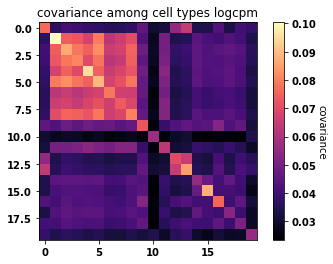

In [15]:
im = plt.imshow(cov_use, cmap ='magma')
# ticks = plt.yticks(np.arange(21), labels = clust_measures[check_specie].columns)
cbar = plt.colorbar(im)
cbar.set_label('covariance',
                       rotation=270,
                       labelpad=10)
plt.title('covariance among cell types logcpm')

In [16]:
pairs_use

[('human', 'macaque'),
 ('human', 'marmoset'),
 ('human', 'mouse'),
 ('macaque', 'marmoset'),
 ('macaque', 'mouse'),
 ('marmoset', 'mouse')]

In [17]:
species =['human', 'macaque', 'marmoset', 'mouse']

In [19]:
out_dir = '../../data/outputs/dmr_gls_results/primate_sequence'

121548 118432
293206 236696


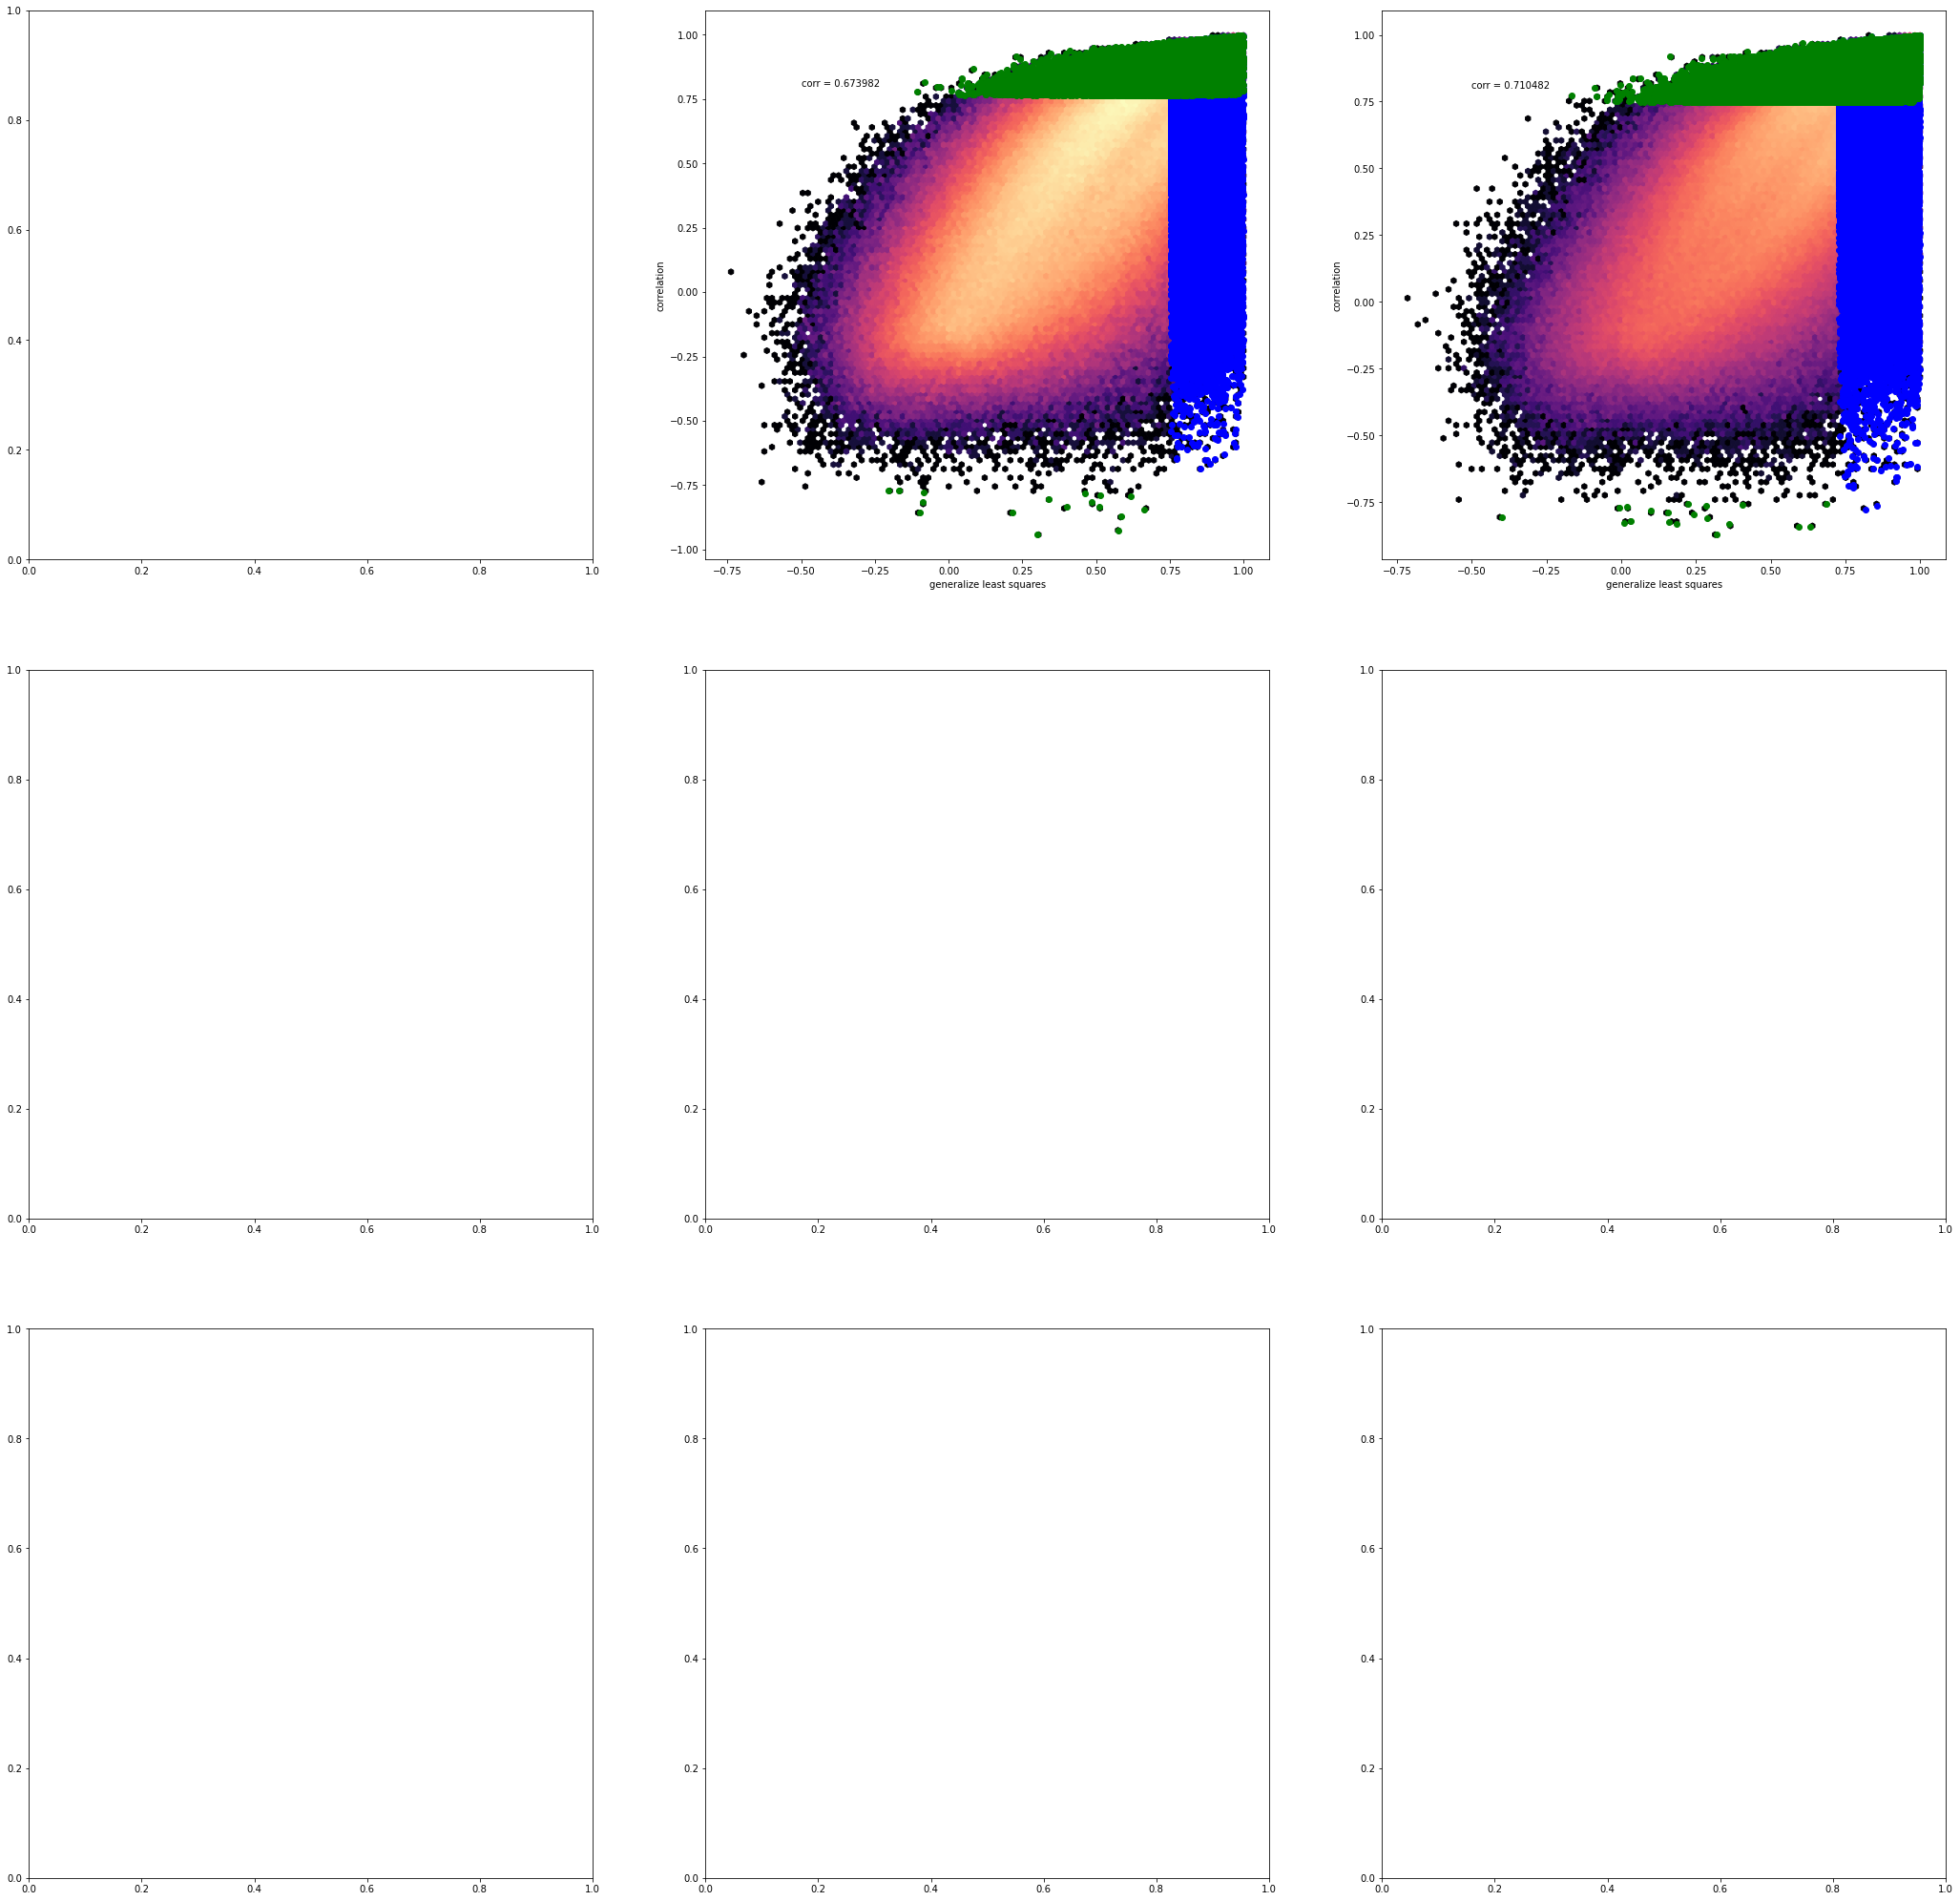

In [21]:
gene_gls = []
gene_corr = []
a_cons = []
p_cons = []

a_bg = []
p_bg = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    if 'mouse' in pair:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv(out_dir + '/gls_inverse_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    x = np.sqrt(stats['r_square']) * np.sign(stats['coeff'])
    y = stats['pear_corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = (stats['fdr'] < .05/6) & (stats['coeff'] > 0)
    sig_corr = stats['fdr_pear'] < .05/6
    gene_gls.append(stats.loc[sig_gls]['Unnamed: 0'].values)
    gene_corr.append(stats.loc[sig_corr]['Unnamed: 0'].values)
    a_cons.append(stats.loc[stats['fdr'] < .05]['Unnamed: 0'].values)
    a_bg.append(stats['Unnamed: 0'].values)
    if 'mouse' not in pair:
        p_cons.append(stats.loc[stats['fdr'] < .05]['Unnamed: 0'].values)
        p_bg.append(stats['Unnamed: 0'].values)
    ax.text(-.5, .8, 'corr = {:4f}'.format(r))
    
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [31]:
def list_intersection(to_intersect):
    common = to_intersect[0]
    for item in to_intersect[1:]:
        common = np.intersect1d(common, item)
    return common

In [32]:
len(list_intersection(a_cons))

24516

In [33]:
len(list_intersection(p_cons))

65676

In [34]:
high_cons = np.unique(np.concatenate(gene_gls))

In [25]:
pair_cons= np.setdiff1d(list_intersection(p_cons), high_cons)

# Relative

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/experimental/relative_gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    x = np.sqrt(stats['r_square']) * np.sign(stats['coeff'])
    y = stats['corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05/2000
    sig_corr = stats['fdr_corr'] < .05/20
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(-.5, .8, 'corr = {:4f}'.format(r))
    
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    ax.scatter(x[sig_corr], y[sig_corr], c='green')    

# examine models

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/experimental/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    # x = np.sqrt(stats['r_square']) * np.sign(stats['coeff'])
    x = stats['t_val']
    y = stats['coeff']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05/6
    sig_corr = stats['fdr_corr'] < .05/20
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

# relative

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/atac_gls_results/experimental/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    # x = np.sqrt(stats['r_square']) * np.sign(stats['coeff'])
    x = stats['t_val']
    y = stats['coeff']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05/6
    sig_corr = stats['fdr_corr'] < .05/20
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    x = stats['pear_corr']
    y = stats['corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05/6
    sig_corr = stats['fdr_corr'] < .05/20
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    x = stats['pear_corr']
    y = stats['corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05/6
    sig_corr = stats['fdr_corr'] < .05/20
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_z_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    # x = stats.t_val
    x = np.sqrt(stats['r_square']) * np.sign(stats['coeff'])
    y = stats['corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = (stats['fdr'] < .05) & (stats['coeff'] > 0)
    sig_corr = stats['fdr_corr'] < .05
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(-.5, 1, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_z_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    x = stats['pear_corr']
    y = stats['corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05/6
    sig_corr = stats['fdr_corr'] < .05/20
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_z_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    x = stats['pear_corr']
    y = stats['corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05/6
    sig_corr = stats['fdr_corr'] < .05/20
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    stats_z = pd.read_csv('../../data/outputs/gex_gls_results/gls_z_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    
    # x = stats.t_val
    x = stats_z['corr']
    y = stats['corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = (stats['fdr'] < .05/2000) & (stats['coeff'] > 0)
    sig_corr = stats['fdr_corr'] < .05
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(-.5, 1, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    stats_z = pd.read_csv('../../data/outputs/gex_gls_results/gls_z_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    
    # x = stats.t_val
    x = stats_z['t_val']
    y = stats['t_val']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('gls zscore')
    ax.set_ylabel('gls no z')
    sig_gls = (stats['fdr'] < .05/2000) & (stats['coeff'] > 0)
    sig_corr = stats['fdr_corr'] < .05
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(10, 1, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/experimental/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    stats_z = pd.read_csv('../../data/outputs/gex_gls_results/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    
    # x = stats.t_val
    x = stats_z['t_val']
    y = stats['t_val']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('gls zscore')
    ax.set_ylabel('gls no z')
    sig_gls = (stats['fdr'] < .05/2000) & (stats['coeff'] > 0)
    sig_corr = stats['fdr_corr'] < .05
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(10, 1, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/experimental/relative_gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    stats_z = pd.read_csv('../../data/outputs/gex_gls_results/relative/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    
    # x = stats.t_val
    x = stats_z['t_val']
    y = stats['t_val']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('gls zscore')
    ax.set_ylabel('gls no z')
    sig_gls = (stats['fdr'] < .05) & (stats['coeff'] > 0)
    sig_corr = (stats['fdr_corr'] < .05) &(stats['coeff'] > 0)
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(10, 1, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
lhx_check = [i.loc['LHX6'] for i in clust_measures.values()]

In [ ]:
check = pd.concat(lhx_check, axis=1)

In [ ]:
im = plt.imshow(check.values)
ticks = plt.yticks(np.arange(21), labels = relative_exp[check_specie].columns)
ticks = plt.xticks(np.arange(4), labels= species, rotation=90)
cbar = plt.colorbar(im)
cbar.set_label('logcpm',
                       rotation=270,
                       labelpad=10)
plt.title('lhx_6 by species')

In [ ]:
lhx_check = [i.loc['SLC17A7'] for i in clust_measures.values()]

In [ ]:
check = pd.concat(lhx_check, axis=1)

In [ ]:
im = plt.imshow(check.values)
ticks = plt.yticks(np.arange(21), labels = relative_exp[check_specie].columns)
ticks = plt.xticks(np.arange(4), labels= species, rotation=90)
cbar = plt.colorbar(im)
cbar.set_label('logcpm',
                       rotation=270,
                       labelpad=10)
plt.title('SLC17A7 by species')

In [ ]:
corr_mat = np.square(np.corrcoef(check.values.T))

In [ ]:
np.fill_diagonal(corr_mat, .74)

In [ ]:
np.corrcoef(check.values.T)

In [ ]:
im = plt.imshow(corr_mat)
ticks = plt.yticks(np.arange(4), labels= species)
ticks = plt.xticks(np.arange(4), labels= species, rotation=90)
cbar = plt.colorbar(im)
cbar.set_label('% variance explained',
                       rotation=270,
                       labelpad=10)
plt.title('SLC17A7 similarity')

In [ ]:
im = plt.imshow(np.corrcoef(check.values.T))
ticks = plt.yticks(np.arange(4), labels= species)
ticks = plt.xticks(np.arange(4), labels= species, rotation=90)
cbar = plt.colorbar(im)
cbar.set_label('Pearson correlation',
                       rotation=270,
                       labelpad=10)
plt.title('SLC17A7 similarity')

In [ ]:
stats_z.loc[stats_z.t_val> 15]

In [ ]:
stats.loc[(stats_z.t_val> 10) & (stats.t_val < 10)]

In [ ]:
stats.loc[stats.human_gene == 'LHX6']

In [ ]:
stats_z.loc[stats.human_gene == 'LHX6']

In [ ]:
stats_z.loc[stats_z.fdr < .05/6].t_val.min()

In [ ]:
stats.loc[stats.fdr < .05/6].t_val.min()

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/relative/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    stats_z = pd.read_csv('../../data/outputs/gex_gls_results/relative/gls_z_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    
    # x = stats.t_val
    x = stats_z['t_val']
    y = stats['t_val']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('gls zscore')
    ax.set_ylabel('gls no z')
    sig_gls = (stats['fdr'] < .05/2000) & (stats['coeff'] > 0)
    sig_corr = stats['fdr_corr'] < .05
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(10, 1, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/relative/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    stats_z = pd.read_csv('../../data/outputs/gex_gls_results/relative/gls_z_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    
    # x = stats.t_val
    x = stats_z['pear_corr']
    y = stats['pear_corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('gls zscore')
    ax.set_ylabel('gls no z')
    sig_gls = (stats['fdr'] < .05/2000) & (stats['coeff'] > 0)
    sig_corr = stats['fdr_corr'] < .05
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(10, 1, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
def list_intersection(to_intersect):
    '''
    get elements in the intersection of a group of lists/arrays
    
    args:
        to_intersect : a list of lists or other listlike objects
    returns:
        common : a numpy array of all elements common in all lists
    
    '''
    common = to_intersect[0]
    for item in to_intersect[1:]:
        common = np.intersect1d(common, item)
    return common

In [ ]:
primate = list_intersection(gene_gls[:3])

In [ ]:
primate_corr = list_intersection(gene_corr[:3])

In [ ]:
len(primate),len(primate_corr)

In [ ]:
len(list_intersection(gene_gls)), len(list_intersection(gene_corr))

In [ ]:
x = [i.loc[list_intersection(gene_gls)].mean(axis=1) for i in clust_measures.values()]

In [ ]:
y = [i.loc[~i.index.isin(list_intersection(gene_gls))].mean(axis=1) for i in clust_measures.values()]

In [ ]:
len(list_intersection(gene_gls)), len(list_intersection(gene_corr)) 

In [ ]:
list_intersection([list_intersection(gene_gls), list_intersection(gene_corr)])

In [ ]:
len(list_intersection([list_intersection(gene_gls), list_intersection(gene_corr)]))

In [ ]:
len(list_intersection(gene_gls))/10790 *  len(list_intersection(gene_corr))/10790

In [ ]:
plt.hexbin(stats['t_val'], stats['coeff'], bins='log', cmap='magma')